In [1]:
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt
import warnings
sys.path.append("../")
from upsetplot import plot, from_contents
from scanpy.plotting.palettes import vega_20_scanpy
from stamarker.dataset import SpatialDataModule
from stamarker.pipeline import STAMarker, make_spatial_data
from stamarker.utils import parse_args, select_svgs
warnings.filterwarnings("ignore")

# Load data

In [2]:
ann_data = sc.read_h5ad("../dataset/rodriques_slideseq.h5ad")
print(ann_data)
data_module = make_spatial_data(ann_data)
data_module.prepare_data(rad_cutoff=40, n_top_genes=3000, min_counts=20)

AnnData object with n_obs × n_vars = 32701 × 6942
    obsm: 'spatial'
After filtering:  (25641, 6942)
------Calculating spatial graph...
The graph contains 237172 edges, 25641 cells.
9.2497 neighbors per cell on average.


# STAMarker training procedure

In [3]:
config = dict()
config.update(parse_args("_params/model.yaml"))
config.update(parse_args("_params/trainer.yaml"))
if not torch.cuda.is_available():
        config["stagate_trainer"]["gpus"] = None
        config["classifier_trainer"]["gpus"] = None
# to use CPU, set the following
# config["stagate_trainer"]["gpus"] = None
# config["classifier_trainer"]["gpus"] = None

In [4]:
# initialize the `STAMarker` object
model = STAMarker(5, "Mouse_cerebellum_output/", config)

In [5]:
# Train autoencoders
model.train_auto_encoders(data_module)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 2


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 3


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 4


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2024-07-14 20:19:38 INFO Finished training 5 auto-encoders


In [7]:
model.clustering(data_module, "louvain", 0.6)

Save louvain results to Mouse_cerebellum_output/version_0\cluster_labels.npy
Save louvain results to Mouse_cerebellum_output/version_1\cluster_labels.npy
Save louvain results to Mouse_cerebellum_output/version_2\cluster_labels.npy
Save louvain results to Mouse_cerebellum_output/version_3\cluster_labels.npy


2024-07-14 20:21:42 INFO Finished 5 clustering with louvain


Save louvain results to Mouse_cerebellum_output/version_4\cluster_labels.npy


Consensus cluster the labels into 5 classes

Save consensus clustering plot to Mouse_cerebellum_output/consensus_clustering.png


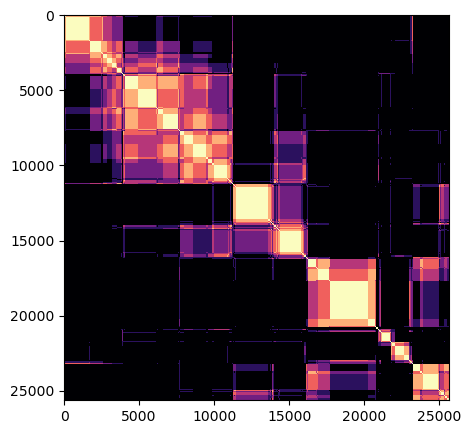

In [8]:
# Perform consensus clustering
# It takes ~73 minutes on a desktop with 
consensus_labels = model.consensus_clustering(5, show_plot=True)

In [9]:
model.train_classifiers(data_module, 5, consensus_labels_path="consensus_labels.npy")

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 2


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 3


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 4


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2024-07-15 10:43:04 INFO Finished training 5 classifiers


In [10]:
smaps = model.compute_smaps(data_module, return_recon=False)

# Visualize spatial domains

In [11]:
consensus_labels = np.load(model.save_dir + "/consensus_labels.npy")
ann_data = copy.copy(data_module.ann_data)
ann_data.obs["Consensus clustering"] = consensus_labels.astype(str)
n_class = np.max(consensus_labels) + 1
print("Num of spatial domains", n_class)

Num of spatial domains 5


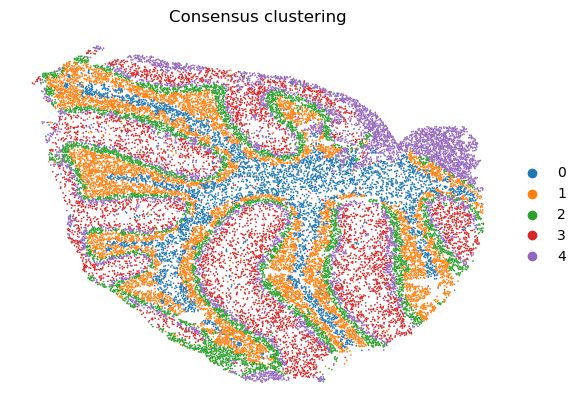

In [12]:
# convert pd to np array for scanpy version changes
ann_data.obsm["spatial"] = ann_data.obsm["spatial"].to_numpy()
sc.pl.embedding(ann_data, basis="spatial", s=6, color="Consensus clustering", frameon=False)

In [13]:
domain_svg_list = []
for domain_ind in range(5):
    domain_svg_list.append(select_svgs(np.log(1 + smaps), domain_ind, consensus_labels, alpha=1.25))
upset_domains_df = from_contents({ f"Spatial domain {ind}": l for ind, l in enumerate(domain_svg_list)})

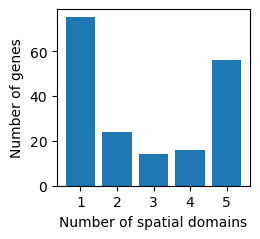

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.5))
df = pd.DataFrame(upset_domains_df.index.to_frame().apply(np.sum, axis=1))
df.columns = ["counts"]
df.index = upset_domains_df["id"]
df_counts = df.groupby("counts")["counts"].agg("count")
ax.bar(df_counts.index, df_counts.values)
ax.set_xticks(df_counts.index)
ax.set_xlabel("Number of spatial domains")
ax.set_ylabel("Number of genes")
plt.tight_layout()